# Example: Measuring T1

T1 is an experiment that measures the relaxation time of a qubit.

Information stored in a qubit decays exponentially. The time constant of the decay is called the relaxation time $T_1$.

The experiment measures $T_1$ by preparing selected qubits in the  excited state by playing an X gate,
waiting some time, and measuring the qubit.

The waiting time is swept to reveal the exponential decay of the excited state probability.

In [1]:
import os
from iqm.pulla.pulla import Pulla

In [2]:
station_control_url = os.environ['PULLA_STATION_CONTROL_URL']  # or set the URL directly here

p = Pulla(station_control_url)
compiler = p.get_standard_compiler()


[01-24 18:26:57;W] Client ('2.12.dev0+local') and/or server ('2.11') is using a local version of the station-control-client. Client and server compatibility cannot be guaranteed.


## Preparing the circuit

High-level QuantumOperations like Quantum gates can be implemented using different GateImplementations.
To control low-level aspects of the execution, we can create custom operations, the implementation of which we can control.

Here we invent a custom operation `"custom"` and write an implementation `"Wait"`, which only inserts a delay of certain duration.
In principle, the custom gate implementation could include any number of low-level instructions,
but for this task we only need a wait.
https://iqm-finland.github.io/docs/iqm-pulse/using_builder.html for more details about lower level controls.

In later cells, we mix the custom gate with other, more familiar gates.

In [3]:
from iqm.pulse.gate_implementation import CompositeGate

class Wait(CompositeGate):
    # GateImplementation for our custom operation. Only adds a delay to a qubit, and nothing else.

    def _call(self, wait_time: float):
        # This will be called when "custom" is encountered during circuit compilation.
        return self.builder.wait(self.locus, wait_time, rounding=True)

We must register the operation, so that the compiler knows what to do with it:

In [4]:
compiler.add_implementation(
    op_name='custom',
    implementation=Wait,
    impl_name='Wait',
    quantum_op_specs={'params': ('wait_time', )}, # Wait has this parameter
    overwrite=True
)

We need to select the physical qubits to work on. These are available on the QPU:

In [5]:
qubits = compiler.builder.chip_topology.qubits_sorted
qubits

('QB1', 'QB2', 'QB3', 'QB4', 'QB5')

Out of these, we select a few:

In [6]:
qubits = qubits[0:2]

Now we create all the circuits. In each circuit, we do a PRX(pi), or X, then our custom operation that waits, then measure all qubits.
We create a circuit for each delay time we want on the time axis.

In [7]:
from iqm.cpc.interface.compiler import Circuit, CircuitOperation as Op
import numpy as np

time_axis = np.linspace(0.0, 300e-6, 51) # In seconds
circuits = []
for wait_time in time_axis:
    
    instructions=[]
    for qubit in qubits:
        instructions += [
            Op("prx", (qubit,), args={"angle": np.pi, "phase": 0.0}),
            Op("custom", (qubit,), args={"wait_time": wait_time}),
        ]                                 
    instructions.append(Op("measure", qubits, args={"key": "M"}))
    circuits.append(Circuit("T1", instructions))
    
circuits[-1]

Circuit(name='T1', instructions=[CircuitOperation(name='prx', locus=('QB1',), args={'angle': 3.141592653589793, 'phase': 0.0}, implementation=None), CircuitOperation(name='custom', locus=('QB1',), args={'wait_time': 0.0003}, implementation=None), CircuitOperation(name='prx', locus=('QB2',), args={'angle': 3.141592653589793, 'phase': 0.0}, implementation=None), CircuitOperation(name='custom', locus=('QB2',), args={'wait_time': 0.0003}, implementation=None), CircuitOperation(name='measure', locus=('QB1', 'QB2'), args={'key': 'M'}, implementation=None)])

Then compile the circuits. We tweak the settings so that the shots are averaged by the server, so that we don't need to.
The results therefore return as sampled probabilities.

In [12]:
playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=500)

# Average over shots. In normal circuit execution, this would be equal to shots:
settings.options.averaging_bins = 1  

In [13]:
job = p.execute(playlist, context, settings, verbose=False)

[01-24 18:27:59;I] Submitted sweep with ID: 740b724a-68e5-4f42-82f8-9709812f852e
[01-24 18:27:59;I] Created task in queue with ID: b80d233e-082e-48dd-8903-f3f4637049ee
[01-24 18:27:59;I] Sweep link: http://varda.qc.iqm.fi/station/sweeps/740b724a-68e5-4f42-82f8-9709812f852e
[01-24 18:27:59;I] Task link: http://varda.qc.iqm.fi/station/tasks/b80d233e-082e-48dd-8903-f3f4637049ee
[01-24 18:27:59;I] Waiting for the sweep to finish...
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.PROGRESS
SweepStatus.SUCCESS
[01-24 18:28:12;I] Sweep status: SweepStatus.SUCCESS


Extract the results

QB1 T1 =  27.5 µs
QB2 T1 =  33.4 µs


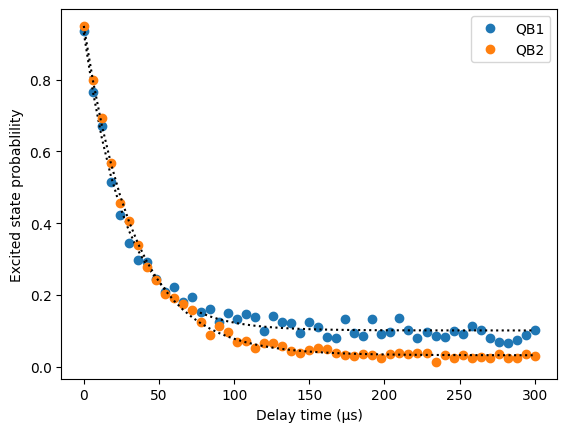

In [14]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exp_func(x, a, b, c):
    return a * np.exp(- x / b) + c

plt.figure()
x = time_axis * 1e6

for i, qubit in enumerate(qubits):
    
    y = np.array([circuit_result["M"][0][i] for circuit_result in job.result])
    popt, _ = curve_fit(exp_func, time_axis, y, p0=[1,50e-6,0])  
    print(f"{qubit} T1 = {popt[1]*1e6 : .1f} µs", )
    
    plt.plot(x, y, 'o', label=qubit)
    plt.plot(x, exp_func(np.array(time_axis), *popt), 'k:')
    
plt.xlabel("Delay time (µs)")
plt.ylabel("Excited state probablility")
plt.legend();

We can also visualise the final playlist. We should see that each circuit is different and the waits at the end are increasing towards the end.

In [15]:
from iqm.pulse.playlist.visualisation.base import inspect_playlist
from IPython.core.display import HTML

HTML(inspect_playlist(playlist, range(5))) # Show first 5 circuits